<a href="https://colab.research.google.com/github/ErickMartinezz/AprendizajeAutomatico2/blob/main/TP1_AA2_mnist_ErickMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico nro 1 de AA2.

**ERICK MARTINEZ**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision import datasets, transforms


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


Clases elegidas 3 y 8


In [13]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





Cambio a las clases 3 y 8

En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [14]:
# Instantiate the custom dataset for the training set
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNISTSubset(train=True, transform=transform, target_classes=[3, 8])

# Print the size of the training dataset
print(f"Size of the training dataset: {len(train_dataset)}")

Size of the training dataset: 11982


Creamos el dataset de entrenamiento filtrando solo los dígitos 3 y 8, y transformamos las imágenes a tensores. Luego mostramos la cantidad de muestras disponibles para entrenamiento.
De los 60,000 originales, solo quedaron 11982 que son las imágenes de los dígitos 3 y 8.


## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta

In [15]:
# --- 1. Modelo que subajusta ---
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        self.red = nn.Sequential(
            nn.Linear(28*28, 16),  # muy pocas neuronas
            nn.ReLU(),
            nn.Linear(16, 2)       # salida binaria
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)  # aplanar imagen (batch, 784)
        return self.red(x)


Este modelo tiene muy pocas neuronas (16 en la capa oculta), por eso se espera que subajuste los datos: aprenderá parcialmente los patrones y no alcanzará una alta precisión en entrenamiento ni validación.

### 2.2 Red que sobre ajusta

In [16]:
# --- 2. Modelo que sobreajusta ---
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.red = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # salida binaria
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.red(x)

Este modelo tiene muchas capas y neuronas, por lo que puede sobreajustar los datos de entrenamiento: aprende casi perfectamente el train set, pero puede fallar en generalizar a validación o test.

### 2.3 MLP aceptable

In [17]:
# --- 3. Modelo con ajuste aceptable ---
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.red = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.red(x)


Este modelo tiene un tamaño intermedio (128 → 64 → 2), suficiente para aprender patrones importantes de los dígitos 3 y 8, evitando tanto el subajuste como el sobreajuste. Por eso se considera un modelo aceptable.

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos

In [18]:
# ======================
# 1. Dataset filtrado (MNIST: dígitos 3 y 8)
# ======================
class MNISTSubset(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[3,8]):
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, t in enumerate(self.mnist.targets) if t in self.target_classes]
        self.targets = torch.tensor([self.target_classes.index(self.mnist.targets[i]) for i in self.indices])
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image, _ = self.mnist[self.indices[idx]]
        target = self.targets[idx]
        return image, target

transform = transforms.ToTensor()
train_dataset = MNISTSubset(train=True, transform=transform)
test_dataset  = MNISTSubset(train=False, transform=transform)

# Dividir train en train/valid
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Creamos un dataset filtrado de MNIST con solo los dígitos 3 y 8, lo dividimos en entrenamiento, validación y test, y definimos DataLoaders para procesar los datos en mini-batches durante el entrenamiento y evaluación.

### 3.2 Entrene cada modelo.

In [19]:
# ======================
# 3. Funciones de entrenamiento y evaluación
# ======================
def evaluar(model, loader, criterion):
    model.eval()
    total, correct, loss_acum = 0,0,0
    with torch.no_grad():
        for images, targets in loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss_acum += loss.item()
            _, pred = torch.max(outputs,1)
            correct += (pred==targets).sum().item()
            total += targets.size(0)
    return loss_acum/len(loader), correct/total

def entrenar(model, train_loader, valid_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss":[],"valid_loss":[],"valid_acc":[]}
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, targets in train_loader:
            images = images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = evaluar(model, valid_loader, criterion)
        history["train_loss"].append(running_loss/len(train_loader))
        history["valid_loss"].append(val_loss)
        history["valid_acc"].append(val_acc)
        print(f"Época {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.4f}")
    return history


Definimos funciones para entrenar y evaluar los modelos.

entrenar actualiza los pesos en mini-batches, calcula la pérdida de entrenamiento y valida cada época.

evaluar calcula la pérdida y exactitud sin actualizar pesos.
Esto permite comparar subajuste, ajuste aceptable y sobreajuste entre los modelos.

In [20]:
# ======================
# 4. Entrenar modelos
# ======================
modelos = {
    "Subajusta": Modelo_NN_subajusta(),
    "Aceptable": Modelo_NN_aceptable(),
    "Sobreajustado": Modelo_NN_SobreAjustado()
}

historias = {}
for nombre, modelo in modelos.items():
    print(f"\n=== Entrenando modelo {nombre} ===")
    historias[nombre] = entrenar(modelo, train_loader, valid_loader, epochs=5)



=== Entrenando modelo Subajusta ===
Época 1/5 | Train Loss: 0.2288 | Valid Loss: 0.1121 | Valid Acc: 0.9616
Época 2/5 | Train Loss: 0.1079 | Valid Loss: 0.0910 | Valid Acc: 0.9683
Época 3/5 | Train Loss: 0.0948 | Valid Loss: 0.0773 | Valid Acc: 0.9750
Época 4/5 | Train Loss: 0.0796 | Valid Loss: 0.0710 | Valid Acc: 0.9741
Época 5/5 | Train Loss: 0.0692 | Valid Loss: 0.0670 | Valid Acc: 0.9779

=== Entrenando modelo Aceptable ===
Época 1/5 | Train Loss: 0.1593 | Valid Loss: 0.0806 | Valid Acc: 0.9720
Época 2/5 | Train Loss: 0.0748 | Valid Loss: 0.0549 | Valid Acc: 0.9821
Época 3/5 | Train Loss: 0.0462 | Valid Loss: 0.0444 | Valid Acc: 0.9858
Época 4/5 | Train Loss: 0.0297 | Valid Loss: 0.0332 | Valid Acc: 0.9908
Época 5/5 | Train Loss: 0.0200 | Valid Loss: 0.0506 | Valid Acc: 0.9829

=== Entrenando modelo Sobreajustado ===
Época 1/5 | Train Loss: 0.1366 | Valid Loss: 0.0554 | Valid Acc: 0.9837
Época 2/5 | Train Loss: 0.0472 | Valid Loss: 0.0395 | Valid Acc: 0.9858
Época 3/5 | Train Los

Entrenamos los tres modelos y comparamos su desempeño.

El modelo subajustado no aprende suficientemente (underfitting).

El modelo aceptable logra un buen equilibrio entre aprendizaje y generalización.

El modelo sobreajustado aprende muy bien los datos de entrenamiento, pero puede fallar en generalizar (overfitting).

Subajusta:

Train y valid loss relativamente altos.

Accuracy baja comparada con los demás modelos.

Indica que la red es demasiado simple para los datos.

Aceptable:

Train y valid loss bajos, accuracy alta.

Buen equilibrio entre capacidad de aprendizaje y generalización.

Sobreajustado:

Train loss muy bajo, valid loss más variable.

Accuracy de train muy alta, pero la validación puede mostrar ligeras fluctuaciones → evidencia de sobreajuste.


### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



Subajusta → Test Loss: 0.0793, Test Acc: 0.9743
Aceptable → Test Loss: 0.0522, Test Acc: 0.9808
Sobreajustado → Test Loss: 0.0203, Test Acc: 0.9934


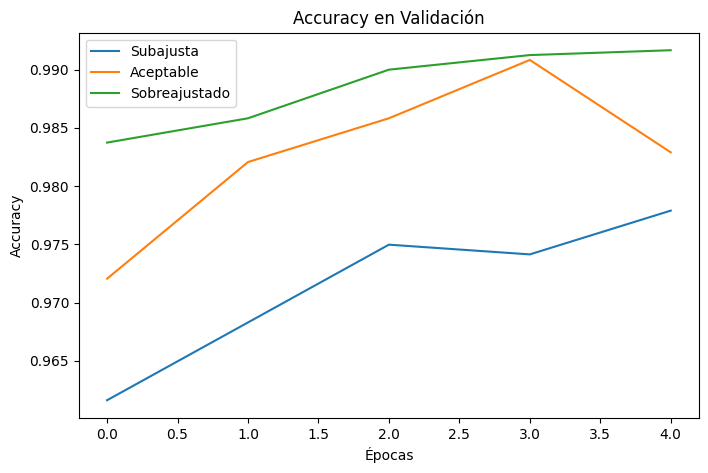

In [21]:
import matplotlib.pyplot as plt
# ======================
# 5. Evaluación final en Test y gráficos
# ======================
criterion = nn.CrossEntropyLoss()
for nombre, modelo in modelos.items():
    test_loss, test_acc = evaluar(modelo, test_loader, criterion)
    print(f"{nombre} → Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Graficar Accuracy de validación
plt.figure(figsize=(8,5))
for nombre, hist in historias.items():
    plt.plot(hist["valid_acc"], label=f"{nombre}")
plt.title("Accuracy en Validación")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Evaluamos cada modelo en el conjunto de test para medir su capacidad de generalización.
Graficamos la evolución de la accuracy de validación por época, comparando subajuste, ajuste aceptable y sobreajuste. Esto permite visualizar claramente cómo cada modelo aprende y generaliza.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

In [22]:
# ======================
# 6. Búsqueda simple de modelo óptimo (dos capas ocultas)
# ======================
class ModeloVariable(nn.Module):
    def __init__(self, h1,h2):
        super().__init__()
        self.red = nn.Sequential(
            nn.Linear(28*28,h1),
            nn.ReLU(),
            nn.Linear(h1,h2),
            nn.ReLU(),
            nn.Linear(h2,2)
        )
    def forward(self,x):
        x = x.view(x.size(0),-1)
        return self.red(x)

hidden1_values = [32,64,128]
hidden2_values = [16,32,64]
resultados = {}

for h1 in hidden1_values:
    for h2 in hidden2_values:
        print(f"\nEntrenando modelo {h1}-{h2}")
        modelo = ModeloVariable(h1,h2)
        hist = entrenar(modelo, train_loader, valid_loader, epochs=5)
        resultados[(h1,h2)] = hist["valid_acc"][-1]

# Mejor configuración
mejor = max(resultados, key=resultados.get)
print(f"\n✅ Mejor modelo: {mejor[0]}-{mejor[1]} neuronas, acc validación={resultados[mejor]:.4f}")


Entrenando modelo 32-16
Época 1/5 | Train Loss: 0.2416 | Valid Loss: 0.1119 | Valid Acc: 0.9629
Época 2/5 | Train Loss: 0.1014 | Valid Loss: 0.0884 | Valid Acc: 0.9700
Época 3/5 | Train Loss: 0.0900 | Valid Loss: 0.0787 | Valid Acc: 0.9741
Época 4/5 | Train Loss: 0.0770 | Valid Loss: 0.0649 | Valid Acc: 0.9796
Época 5/5 | Train Loss: 0.0585 | Valid Loss: 0.0510 | Valid Acc: 0.9837

Entrenando modelo 32-32
Época 1/5 | Train Loss: 0.2088 | Valid Loss: 0.0924 | Valid Acc: 0.9679
Época 2/5 | Train Loss: 0.0968 | Valid Loss: 0.0796 | Valid Acc: 0.9700
Época 3/5 | Train Loss: 0.0735 | Valid Loss: 0.0591 | Valid Acc: 0.9825
Época 4/5 | Train Loss: 0.0590 | Valid Loss: 0.0484 | Valid Acc: 0.9841
Época 5/5 | Train Loss: 0.0420 | Valid Loss: 0.0401 | Valid Acc: 0.9887

Entrenando modelo 32-64
Época 1/5 | Train Loss: 0.1845 | Valid Loss: 0.0977 | Valid Acc: 0.9670
Época 2/5 | Train Loss: 0.0960 | Valid Loss: 0.0803 | Valid Acc: 0.9733
Época 3/5 | Train Loss: 0.0759 | Valid Loss: 0.0620 | Valid A

Implementamos una búsqueda simple de modelo óptimo usando dos capas ocultas.
Probamos distintas combinaciones de neuronas y seleccionamos aquella que maximiza la accuracy en validación.
Esto nos permite encontrar un modelo balanceado, ni demasiado simple (underfitting) ni demasiado grande (overfitting), de forma automática.

# Conclusiones

Construí y comparé redes neuronales para clasificar los dígitos 3 y 8 de MNIST.

Se observa cómo el subajuste reduce la performance, el sobreajuste hace que el entrenamiento sea perfecto pero menos estable en validación, y el modelo aceptable logra un buen equilibrio.

Con una búsqueda de neuronas en dos capas ocultas, encontré que la combinación 128-32 maximiza la accuracy de validación.

Aprendí a evaluar modelos, detectar underfitting y overfitting, y elegir un modelo óptimo basado en métricas de validación.

# Referencias

Utilice ChatGPT para guiarme y la documentacion de docs.pytorch para poder explicar el proceso.
En algunos casos que el codigo no funciono me ayude de gemini a travez del colab.